<a href="https://colab.research.google.com/github/cleysonl/Pytorch/blob/master/CIFAR10_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIFAR10 using CNNs with PyTorch**

In [15]:
!pip install torch torchvision

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## **Transformations and Data Augmentation**

In [19]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear = 10, scale = (0.8, 1.2)),
                                      transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])
transform = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])
training_dataset = datasets.CIFAR10(root = './data', train = True, download = True, transform = transform_train)
validation_dataset = datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size = 100, shuffle = True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size =100, shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


## **Image Conversion Function**

In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  # image = image[:,:,0]
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0,1)
  return image

## **Defining Classes**

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')  

## **Plotting Image Data**

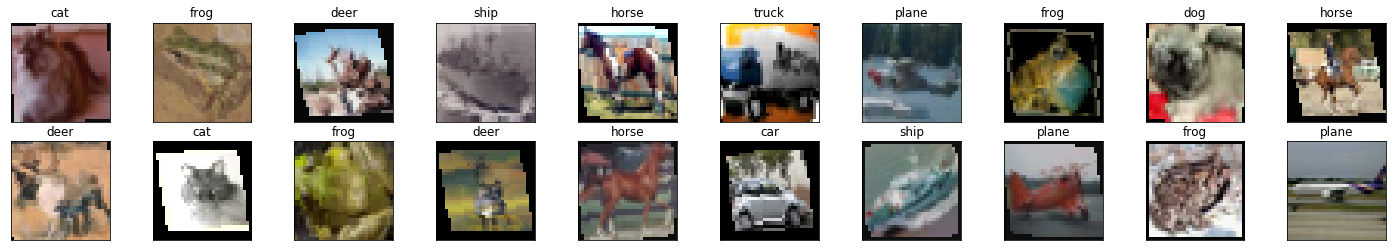

In [27]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize =(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks = [], yticks = [])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

## **Model Class Constructor**

In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
    self.fc1 = nn.Linear(4*4*64, 500)
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)
  def forward (self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = x.view(-1, 4*4*64)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

## **Declaring Classifier**

In [30]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

## **Loss and Optimizer**

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

## **Training Process**